# Case Study: Math PhD Exchange

This data set is derived from the article ["Eigenvector-Based Centrality Measures for Temporal Networks
"](https://arxiv.org/abs/1507.01266) by Taylor, Myers, Clauset, Porter, and Mucha, which was in turn scraped from the [Mathematics Geneology Project](https://www.genealogy.math.ndsu.nodak.edu/). There is an entry $i\rightarrow j$ in year $t$ if a mathematician graduated in year $t$ from university $j$ and thereafter supervised at least one PhD thesis at university $i$. This is a proxy for hiring data: we are assuming, essentially, that this mathematician was hired ("endorsed") by $i$ in or around year $t$. 

## Data Limitations

There are several limitations in these data implied by the collection process. 

1. If a mathematician is hired in year $t$, then they are unlikely to show up in the data set until roughly year $t+\tau$, where $\tau\approx 5 \pm 2$ is the approximate amount of time required to complete a PhD thesis. 
2. If a mathematician is hired sequentially by departments $i$ and $i'$, both $i$ and $i'$ will be taken to have endorsed this mathematician *in the same year* $t$, even though the actual time in which $i'$ hired the mathematician may be well after $i$. This raises the potential for causality violations. 

To address limitation 1., we omit the final six years of the data set. We'll study the years 1960-2000. 

In [1]:
import numpy as np


from py.utils import *
from py.prep_data import *
from py.model import model
from py.scores import homebrew_SpringRank_score, fiedler_vector_score, powered_degree_score, katz_score, PageRank_score
from numba import jit


# visualization

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
from matplotlib.gridspec import GridSpec


# Data Preparation

First we read the data. In order to ensure connectedness of the endorsement matrix across many time periods, we restrict the data to only the top 100 schools by placement. 

In [2]:
data_dir = 'data/PhD Exchange Network Data/'

n = 70
T, labels, timesteps = prep_math_phd(data_dir, top_n = n) 

# T is a sequence of 61 matrices of size 100 x 100, one for each year 1946-2006 
# T.shape, timesteps

In order to ensure that the endorsement matrix is weakly connected at the initial condition, we are going to take all of the pre-1960 data and aggregate it into the initial state matrix. In order to address limitation 1) above, we are also going to exclude the years 2001-onward from analysis. 

In [3]:
T, timesteps, A0, n_obs = initial_condition(T, timesteps, t_start = 14, t_end = 55)
# timesteps # the years remaining in the data are: 

In [4]:
n_obs

6019.0

# Inference

Now we're ready to try to learn the model on some data. In the paper, the instantaneous rate of endorsements to $j$ is given by $\gamma_j \propto e^{\beta s_j}$. This rate is independent of the identity of the endorser. 

The model used here is an extension in two respects. First, we use a more general rate $\gamma$ that depends on the identity of both the endorser and the endorsed: 

$$\gamma_{ij} \propto e^{\beta_1s_j + \beta_2 (s_i - s_j)^2}$$

The incorporation of the quadratic term in the exponent governs a tendency for agents to endorse each other when they are nearby in the hierarchy. If $\beta_1$ is negative, endorsements that span large swaths of rank-space are discouraged. For example, in the context of faculty hiring, negative values of $-\beta_2$ would discourage cases in which a very low-ranked school was able to hire a candidate from a very high-ranked school. The model that we have been considering can be recovered by fixing $\beta_2 = 0$. 

Second, we also consider a version of this model in which, instead of $s_j$ denoting the SpringRank of $j$, we set $s_j = \sqrt{d_j}$. In this case, it doesn't matter "where" you are in the hierarchy, only the total number of endorsements you've received. 

The result of SpringRank-based inference is:

In [17]:
L_SR = model()

L_SR.set_score(
    score_function = lambda A: homebrew_SpringRank_score(A.T + .01, alpha = .01)
)

def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

L_SR.set_features([
    linear_feature, 
    quadratic_feature
])

L_SR.set_data(T, A0)

pars_SR = L_SR.ML(lam0 = .8, 
           alpha0 = 10**(-4), 
           tol = 10**(-3), 
           step_cap = .05,
           print_updates = False, 
           align = False)
pars_SR

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.9124590866580549,
 'beta': array([ 3.9022899 , -1.80998937]),
 'LL': -20991.241035440347}

The result of degree-based inference is: 

In [6]:
# degree-based inference: this call should be faster

L_deg = model()

L_deg.set_score(
    score_function = lambda A: powered_degree_score(A, p = 0.5)
)

L_deg.set_features([
    lambda s: linear_feature(np.sqrt(s)), 
    lambda s: quadratic_feature(np.sqrt(s))
])

L_deg.set_data(T, A0)

pars_deg = L_deg.ML(lam0 = .7, 
           alpha0 = 10**(-4), 
           tol = 10**(-3), 
           step_cap = .05,
           print_updates = False, 
           align = False)
pars_deg

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.876653960128897,
 'beta': array([ 3.48916755, -1.24559892]),
 'LL': -20426.36834292718}

In [8]:
L_L = model()


L_L.set_score(
    score_function = fiedler_vector_score
)

L_L.set_features([
    lambda s: linear_feature(s), 
    lambda s: quadratic_feature(s)
])

L_L.set_data(T, A0)

pars_L = L_L.ML(lam0 = .9, 
           alpha0 = 10**(-2), 
           tol = 10**(-3), 
           step_cap = .1,
           print_updates = True, 
           align = True)
pars_L

computing memory hyperparameter lambda
Lambda = 0.85, LL = 24667.07632880564
Lambda = 0.95, LL = 24655.272535829536
Lambda = 1.0, LL = 24495.74009365242
Lambda = 1.00625, LL = 24437.318554151785
Lambda = 1.00703125, LL = 24435.454983521846
Lambda = 1.0068359375, LL = 24435.355835316896
Lambda = 1.00693359375, LL = 24435.340361063834
Lambda = 1.006884765625, LL = 24435.333153984735
Lambda = 1.0068847656017168, LL = 24435.333153982567
computing parameter vector beta


{'lam': 1.0068847656017168,
 'beta': array([-14.0381134 , -16.53015912]),
 'LL': -24435.333153982567}

In [9]:
L_K = model()

L_K.set_score(
    score_function = lambda A: katz_score(A.T, alpha = .1)
)

L_K.set_features([
    lambda s: linear_feature(s), 
    lambda s: quadratic_feature(s)
])

L_K.set_data(T, A0)

pars_K = L_K.ML(lam0 = 0.5, 
           alpha0 = 10**(-2), 
           tol = 10**(-6), 
           step_cap = .1,
           print_updates = True, 
           align = False)
pars_K

computing memory hyperparameter lambda


/Users/philchodrow/Dropbox (MIT)/projects/!side_projects/prestige_reinforcement/py/scores.py:38: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  return(np.linalg.inv(I - alpha*A).dot(e))


Lambda = 0.6, LL = 21443.65188919273
Lambda = 0.7, LL = 21351.669837136422
Lambda = 0.7999999999999999, LL = 21260.57805832429
Lambda = 0.8999999999999999, LL = 21167.719082845982
Lambda = 0.9999999999999999, LL = 21118.934008602613
Lambda = 0.9749999999999999, LL = 21108.143346132074
Lambda = 0.9874999999999998, LL = 21105.64693428574
Lambda = 0.9843749999999998, LL = 21105.422632429636
Lambda = 0.9851562499999997, LL = 21105.408160845796
Lambda = 0.9849609374999997, LL = 21105.407708331397
Lambda = 0.9850504058978455, LL = 21105.407571758642
Lambda = 0.985024272294653, LL = 21105.407551793825
Lambda = 0.9850242722866233, LL = 21105.407551793825
computing parameter vector beta


{'lam': 0.9850242722866233,
 'beta': array([ 1.49529153, -0.27421584]),
 'LL': -21105.407551793825}

In [14]:
# pagerank!

L_PR = model()

    
L_PR.set_score(
    score_function = lambda A: PageRank_score(A.T + .01)
)

L_PR.set_features([
    linear_feature, 
    quadratic_feature
])

L_PR.set_data(T, A0)

pars_PR = L_PR.ML(lam0 = .7, 
           alpha0 = 10**(-2), 
           tol = 10**(-3), 
           step_cap = .1,
           print_updates = True, 
           align = False)
pars_PR

computing memory hyperparameter lambda
Lambda = 0.7999999999999999, LL = 20882.11207471496
Lambda = 0.8999999999999999, LL = 20846.764574689518
Lambda = 0.95, LL = 20839.54405740634
Lambda = 0.9468749999999999, LL = 20839.534264182807
Lambda = 0.9484374999999999, LL = 20839.52613168525
Lambda = 0.9479346520720809, LL = 20839.525964675107
computing parameter vector beta


{'lam': 0.9479346520720809,
 'beta': array([  73.34165885, -623.397811  ]),
 'LL': -20839.525964675107}

These results suggest that the degree-based feature model may be preferable to the SpringRank model, based on its higher log-likelihood (LL). Other points to note are that the models give very similar estimates for $\lambda$, indicating that they agree on the relevant timescales for prediction in these data. 

Let's proceed with the degree-based parameters. 

In [16]:
# batch standard errors

d = {
    'SR': [L_SR, pars_SR],
    'deg': [L_deg, pars_deg],
    'PR': [L_PR, pars_PR]
}

for key in d: 
    L = d[key][0]
    pars = d[key][1]
    H = L.estimate_hessian(pars['lam'], pars['beta'])
    V = np.linalg.inv(-H) # covariance matrix
    print(key + ': ' + str(np.round(np.sqrt(np.diag(V)), 3)))

SR: [0.006 0.045 0.043]
deg: [0.012 0.017 0.007]
PR: [5.0000e-03 7.6500e-01 1.2252e+01]


In [18]:
pars = pars_deg
L = L_deg

In [ ]:
# batch uncertainties



# Parameter Uncertainty

Now let's estimate the covariance matrix of the parameters by inverting the Hessian matrix of the likelihood function at the parameters we solved for. 

In [19]:
# again might take a little while

H = L.estimate_hessian(pars['lam'], pars['beta'])
V = np.linalg.inv(-H) # covariance matrix
np.sqrt(np.diag(V))

array([0.00957747, 0.04663137, 0.05157174])

In [20]:
pars['beta']

array([ 3.48916755, -1.24559892])

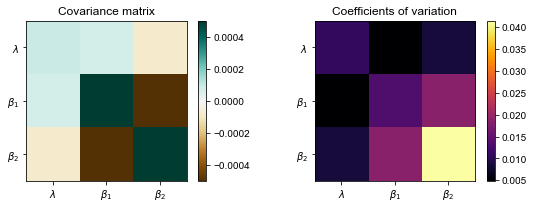

In [21]:
fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(121)
im = ax.imshow(V, cmap = 'BrBG', vmin = -0.0005, vmax = 0.0005) # estimated covariance matrix
plt.colorbar(im)
t = ax.set_title('Covariance matrix')
plt.xticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])
plt.yticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])

ax = fig.add_subplot(122)
p = np.concatenate(([pars['lam']], pars['beta']))
im = ax.imshow(np.sqrt(V/np.outer(p,p)), cmap = 'inferno')    # coefficient of variation
plt.colorbar(im)

plt.xticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])
plt.yticks([0,1,2], [r'$\lambda$', r'$\beta_1$', r'$\beta_2$'])

t = ax.set_title('Coefficients of variation')

plt.tight_layout()

plt.savefig('fig/math_phd_cv.png', dpi = 300)

The model is extremely confident about its prediction in $\lambda$, indicated by the fact that the rows and columns corresponding to $\lambda$ are very small. There is a negative correlation between $\beta_1$ and $\beta_2$, indicating that there are regions of parameter space that are "nearly as good" (as measured by the likelihood) in which $\beta_1$ is smaller and $\beta_2$ is larger, or vice-versa. 

How "big" is the covariance matrix relative to the data? Not too large! The coefficients of variation for each pair of variables are all well below $5\%$, indicating that we can be roughly 95% confidence of our estimates within 10% accuracy or better. The greatest amount of relative uncertainty is in the estimate of $\beta_2$. 

While this is a highly informal approach and should not be confused with actual statistics, the small coefficients of variation are heuristic evidence that all the parameters are significantly different from zero. 

# Snapshot of model prediction

The mini-study below considers how the model ''works.'' 

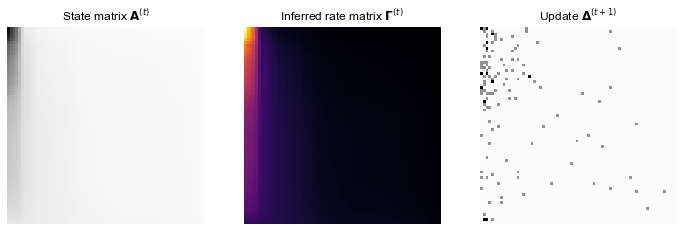

In [22]:
# snapshot of the state and cumulative hiring matrix at specified time i

# A = state_matrix(T, A0 = A0, lam = pars['lam'])

# S = SR_quadratic_feature(A)

i = 20

V = L.GAMMA[i]
# V = softmax(S, np.array([2.8, 0]))[i]

fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(131)
ax.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(V, -V.sum(axis = 0)), vmax = .2,  cmap = 'Greys', alpha = .99)
ax.set(title = r'State matrix $\mathbf{A}^{(t)}$')
ax.axis('off')

ax = fig.add_subplot(132)
# plt.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1)
ax.imshow(matrix_sort(V, -V.sum(axis = 0)), alpha = .995, cmap = 'inferno')
ax.set(title = 'Inferred rate matrix $\mathbf{\Gamma}^{(t)}$')
plt.gca().axis('off')

ax = fig.add_subplot(133)
ax.imshow(np.ones_like(T[i]), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(T[i+1]-T[i], -V.sum(axis = 0)), vmax = 2,  cmap = 'Greys', alpha = .99)
ax.set(title = 'Update $\mathbf{\Delta}^{(t+1)}$')
ax.axis('off')
# plt.colorbar()

plt.savefig('fig/math_phd_illustration.png', dpi = 300, bbox_inches = 'tight')

On the far left, we show the model state $A_t$ at time $t = 30$. Each entry of this matrix is a weighted sum of previous hiring events: $A_{ij}^{(t)} = \sum_{\tau = 1}^t \lambda^\tau E_{ij}^{(\tau)}$, where $E_{ij}^{(\tau)}$ is the number of times $i$ endorsed $j$ in time period $\tau$. This matrix is an input into the rate matrix $\Gamma$, which is shown in the center. This is a matrix of predictions about endorsements in the next time-step: entry $\gamma_{ij}$ is proportional to the predicted probability that $i$ will endorse $j$ in the next timestep. Finally, we can (heuristically) compare the rate matrix to the observed update at time $t+1$, noting that the bulk of endorsement events do indeed occur in regions of high probability specified by the rate matrix. 

# Inferred rank dynamics

Now let's visualize the evolution of this system as understood by the model. It's of possible interest to visualize at least two distinct objects. The first is the overall modeled endorsement rate, which predicts the rate of endorsements of $j$ in the next timestep. The second is the intrinsic ranks modeled for each individual school. 

In [23]:
# cosmetics

shortener = {
    'Massachusetts Institute of Technology' : 'MIT',
    'University of California, Berkeley' : 'Berkeley', 
    'Stanford University' : 'Stanford',
    'Princeton University' : 'Princeton',
    'Harvard University' : 'Harvard',
    'Yale University' : 'Yale',
    'The University of Chicago' : 'Chicago',
    'California Institute of Technology' : 'Caltech',
    'Cornell University' : 'Cornell'
}

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [24]:
highlight = ['MIT', 'Berkeley', 'Stanford', 'Princeton', 'Harvard', 'Cornell']

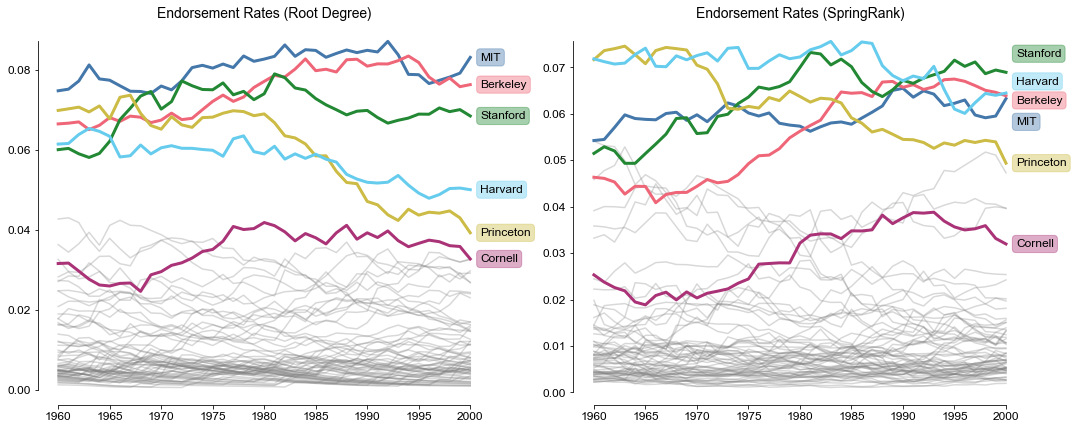

In [27]:
fig = plt.figure(figsize = (15,6))

# FIRST PLOT

ax = fig.add_subplot(121)

# A = state_matrix(T, A0 = A0, lam = pars['lam'])
# S = feature_fun(A)

GAMMA = L.GAMMA.mean(axis = 1)
# GAMMA = softmax(S, pars['beta']).sum(axis = 1)
# GAMMA = GAMMA / GAMMA.sum(axis = 1)[:,np.newaxis]

top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

# GAMMA = np.sort(GAMMA, axis = 1)
# for i in range(6, top_n):
p = ax.plot(timesteps, GAMMA, color = 'grey', alpha = .3)

# k = 0
# for i in top_trajectories:
#     ax.plot(timesteps, GAMMA[:,i], color = cset[k], alpha = 1)
#     k += 1
k = 0

label_adjustments = {
    'MIT': -0.000,
    'Berkeley' : 0.000,
    'Harvard': 0.000,
    'Stanford' : .000,
    'Chicago' : 0,
    'Princeton' : .000, 
    'Yale' : -0.00,
    'Caltech' : -0.000,
    'Cornell' : 0.00
}

for l in range(n):
    long_name = labels[l]
    if long_name in shortener: 
        name = shortener[long_name]
        if name in highlight:         
            ax.plot(timesteps, GAMMA[:,l], alpha = 1, linewidth = 3, 
                     label = name, color = cset[k])

            ax.annotate(shortener[labels[l]],
                      xy=(timesteps.max(), GAMMA[-1:,l] + label_adjustments[name]), xycoords='data',
                      xytext=(10, 0), textcoords='offset points',
                      size=12, va="center", color = 'black',
                      bbox=dict(boxstyle="round",  color = cset[k], alpha = .4))
        
            k += 1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds(0, GAMMA.max())
ax.spines['bottom'].set_bounds(timesteps.min(), timesteps.max())

ax.set(title = 'Endorsement Rates (Root Degree)')


# SECOND PLOT

ax = fig.add_subplot(122)

GAMMA = L_SR.GAMMA.mean(axis = 1)

top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

# GAMMA = np.sort(GAMMA, axis = 1)
# for i in range(6, top_n):
p = ax.plot(timesteps, GAMMA, color = 'grey', alpha = .3)

# k = 0
# for i in top_trajectories:
#     ax.plot(timesteps, GAMMA[:,i], color = cset[k], alpha = 1)
#     k += 1
k = 0

label_adjustments = {
    'MIT': -0.005,
    'Berkeley' : -0.001,
    'Harvard': 0.0025,
    'Stanford' : .004,
    'Chicago' : -0.001,
    'Princeton' : 0.000, 
    'Yale' : -0.001,
    'Caltech' : -0.004,
    'Cornell' : 0.000
}

k = 0

for l in range(n):
    long_name = labels[l]
    if long_name in shortener: 
        name = shortener[long_name]
        if name in highlight:         
            ax.plot(timesteps, GAMMA[:,l], alpha = 1, linewidth = 3, 
                     label = name, color = cset[k])

            ax.annotate(shortener[labels[l]],
                      xy=(timesteps.max(), GAMMA[-1:,l] + label_adjustments[name]), xycoords='data',
                      xytext=(10, 0), textcoords='offset points',
                      size=12, va="center", color = 'black',
                      bbox=dict(boxstyle="round",  color = cset[k], alpha = .4))
        
            k += 1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds(0, GAMMA.max())
ax.spines['bottom'].set_bounds(timesteps.min(), timesteps.max())

ax.set(title = 'Endorsement Rates (SpringRank)')

plt.tight_layout()

plt.savefig('fig/math_phd_ranks.png', dpi = 300)